In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
#MNIST images. -> pytorch tensors
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root = '../Data',train = True,download=True,transform = transform)

In [4]:
test_data = datasets.MNIST(root = '../Data',train = False,download=True,transform = transform)

In [5]:
type(train_data)

torchvision.datasets.mnist.MNIST

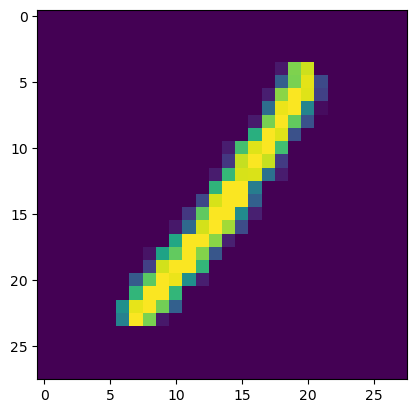

In [6]:
import random
num = random.randint(0,60000)
plt.imshow(train_data[num][0].reshape(28,28))

In [7]:
img,label = train_data[num-1]

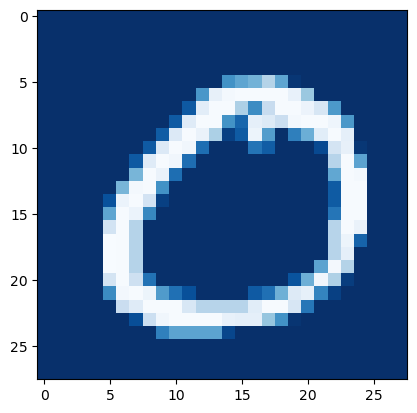

In [8]:
plt.imshow(img.reshape(28,28),cmap='Blues_r')

In [9]:
torch.manual_seed(101)
device = torch.device("mps")
train_batch_size = 100
test_batch_size = 500
train_loader = DataLoader(train_data,batch_size=train_batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_batch_size,shuffle=False)

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


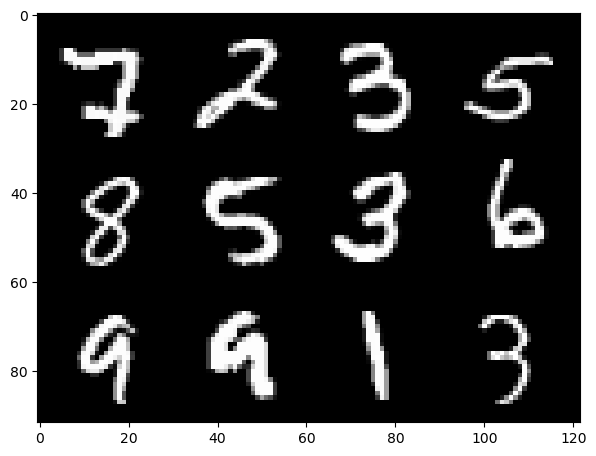

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int= lambda x: f'{x:4}'))
for images,labels in train_loader:
    break
print('Labels: ',labels[:12].numpy())
im = make_grid(images[:12],nrow=4)
plt.figure(figsize=(7,7))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### Model

In [11]:
class Model(nn.Module):
    
    def __init__(self,in_size=784,out_size=10,layers = [128,64,32]):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(in_size,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],layers[2])
        self.out = nn.Linear(layers[2],out_size)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [12]:
torch.manual_seed(101)
model = Model(layers=[128,64,32]).to(device)
model

Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
total = 0
for p in model.parameters():
    total += p.numel()
    print(p.numel())
print("Total :", total)

100352
128
8192
64
2048
32
320
10
Total : 111146


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [15]:
#change shape - >[100,784]
images.shape

torch.Size([100, 1, 28, 28])

In [16]:
images.view(100,-1).shape

torch.Size([100, 784])

### Training

In [ ]:
import time
start_time = time.time()

num_epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct= []

for epoch in range(num_epochs):
    trn_crt = 0
    tst_crt = 0
    for b,(X_train,y_train) in enumerate(train_loader):
        X_train,y_train = X_train.to(device),y_train.to(device)
        b += 1
        y_pred = model.forward(X_train.view(100,-1))
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred.data,1)[1]
        batch_correct = (predicted == y_train).sum()
        trn_crt += batch_correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_crt*100/(100*b)
            print(f'epoch : {epoch+1} batch : {b} loss : {loss.item()} accuracy : {acc}')
            
    train_losses.append(loss)
    train_correct.append(trn_crt)
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            X_test,y_test = X_test.to(device),y_test.to(device)
            y_val = model.forward(X_test.view(test_batch_size,-1))
            predicted = torch.max(y_val.data,1)[1]
            tst_crt += (predicted == y_test).sum()
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_crt)






end_time = time.time()
print(f"{(end_time-start_time)/60} mins")

In [17]:
for epoch in range(10):
    crt = 0
    len_y =0
    for X_train,y_train in train_loader:
        X_train,y_train = X_train.to(device),y_train.to(device)
        y_pred = model.forward(X_train.view(train_batch_size,-1))
        pred = torch.max(y_pred.data,1)[1]
        crt += (pred == y_train).sum()
        len_y += len(y_train)
        loss = criterion(y_pred,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    acc = crt*100/len_y
    print(f"epoch : {epoch+1} loss : {loss.item()} acc : {acc}")
    

epoch : 1 loss : 0.2256438136100769 acc : 85.711669921875
epoch : 2 loss : 0.1851075291633606 acc : 94.95166778564453
epoch : 3 loss : 0.1234527975320816 acc : 96.3066635131836
epoch : 4 loss : 0.13614533841609955 acc : 97.11333465576172
epoch : 5 loss : 0.03226545825600624 acc : 97.7316665649414
epoch : 6 loss : 0.0214059017598629 acc : 98.07166290283203
epoch : 7 loss : 0.05404778942465782 acc : 98.39167022705078
epoch : 8 loss : 0.022585554048419 acc : 98.72333526611328
epoch : 9 loss : 0.01889890991151333 acc : 98.80000305175781
epoch : 10 loss : 0.04473550617694855 acc : 99.02999877929688
